# Hands-on Day 2

## You'll learn

### ML methods

- Multilayer Perceptron Classifier (MCP) with pyspark.ml

### ML techniques
- hyperparameter optimisation
- ROC curves

In [22]:
#initial imports
%reload_ext custom_magics
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:

# initial setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Check out these custom functions
from custom_functions import *

In [9]:
num_workers=10
spark=%sc $num_workers

from pyspark.sql import SparkSession
spark_session = SparkSession(spark)

#check if spark is there
spark

<SparkContext master=k8s://https://192.168.2.39:6443 appName=jupyter-marchisi01>

# Data preprocessing

In [10]:
inputFile = 'file:///home/jovyan/Higgs100k.parquet'
#inputFile = 'file:///home/jovyan/Higgs1M.parquet'
#inputFile = 'file:///home/jovyan/Higgs10M.parquet'

%time df = spark_session.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

total_events = df.count()
print('There are '+str(total_events)+' events')

CPU times: user 2.17 ms, sys: 378 µs, total: 2.54 ms
Wall time: 1.15 s
There are 99999 events


In [11]:
#split the dataset for training and test
train, test = df.randomSplit([0.8,0.2])

print('Events for training {}'.format(train.count()))
print('Events for validation {}'.format(test.count()))

Events for training 79922
Events for validation 20077


In [12]:
# create the input feature vector 
feature = train.columns
feature.remove('label')

from pyspark.ml.feature import VectorAssembler

#VectorAssembler is a transformer that combines a given list of columns into a single vector column
assembler = VectorAssembler(inputCols=feature, outputCol='features')
train = assembler.transform(train)
test = assembler.transform(test)

# ML models: MCP

## Exercise 1

- Implement a shallow NN: use *MultiLayerPerceptronClassifier* from pyspark
- documentation: https://spark.apache.org/docs/latest/ml-classification-regression.html#multilayer-perceptron-classifier
- implement a network with: 
  - one input layer of size 28 (our features), 
  - two intermediate layers of size 30,
  - one output of size 2 (the label classes)
  - other hyerparameters: maxIter=100, blockSize=128, seed=1234
- plot the various metrics (ROC, signal vs background)
- bonus: do hyperparameter optimisation

In [14]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

layers = [28, 30, 2]

mlpc = MultilayerPerceptronClassifier(maxIter = 100,
                                            blockSize = 128,
                                            seed = 1234,
                                            layers = layers)

In [15]:
%%time
model_mlpc = mlpc.fit(train)

CPU times: user 10.6 ms, sys: 6.2 ms, total: 16.8 ms
Wall time: 23.3 s


Test set AUC = 0.7269827534437417


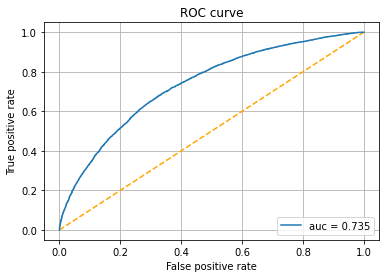

In [16]:
# compute accuracy on the test set
from pyspark.ml.evaluation import BinaryClassificationEvaluator

result = model_mlpc.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")
print("Test set AUC = " + str(evaluator.evaluate(result)))

#make ROC curve
drawROC(result)

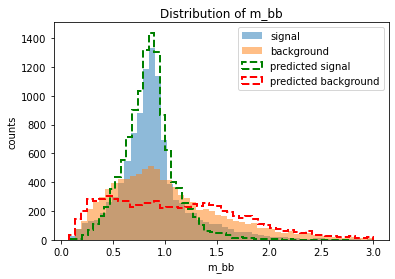

In [17]:
#plot signal vs background with prediction
plotSignalvsBgWithPrediction(test, result, 'm_bb')

#### Hyperparameter tuning



In [18]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create a new MLPC instance for tuning
mlpc_tuning = MultilayerPerceptronClassifier(seed=1234)

In [19]:
# Build the parameter grid
# Note: layers must keep input size (28) and output size (2) fixed
paramGrid = ParamGridBuilder() \
    .addGrid(mlpc_tuning.layers, [[28, 30, 2], [28, 30, 30, 2], [28, 50, 2], [28, 50, 50, 2]]) \
    .addGrid(mlpc_tuning.maxIter, [50, 100]) \
    .addGrid(mlpc_tuning.blockSize, [64, 128]) \
    .build()

In [20]:
# Create evaluator
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderROC')

# Create CrossValidator
crossval = CrossValidator(estimator=mlpc_tuning,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)


In [25]:
# Run cross-validation and get the best model
print("Starting hyperparameter tuning with CrossValidator...")
print(f"Number of parameter combinations: {len(paramGrid)}")

Starting hyperparameter tuning with CrossValidator...
Number of parameter combinations: 16


In [26]:
%%time
cvModel = crossval.fit(train)

CPU times: user 1.07 s, sys: 532 ms, total: 1.6 s
Wall time: 8min 42s



Best model parameters:
  Layers: [28, 30, 30, 2]
  Max Iterations: 100
  Block Size: 64

Best model Test set AUC = 0.7205706315825792

Best model Test set AUC = 0.7205706315825792


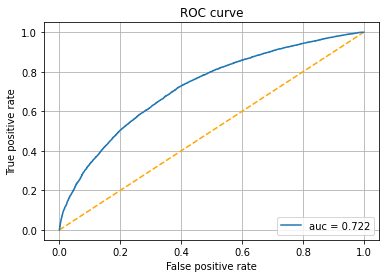

In [27]:
# Get best model and evaluate on test set
bestModel = cvModel.bestModel
print("\nBest model parameters:")
print(f"  Layers: {bestModel.getLayers()}")
print(f"  Max Iterations: {bestModel.getMaxIter()}")
print(f"  Block Size: {bestModel.getBlockSize()}")

# Evaluate best model on test set
result_tuned = bestModel.transform(test)
auc_tuned = evaluator.evaluate(result_tuned)
print(f"\nBest model Test set AUC = {auc_tuned}")

# Plot ROC curve for the best model
drawROC(result_tuned)

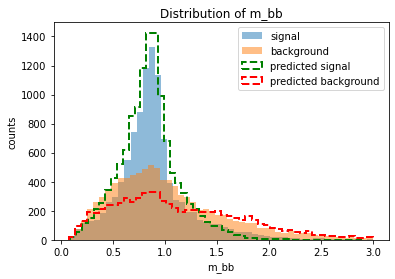

In [28]:
# plot signal vs background with prediction
plotSignalvsBgWithPrediction(test, result_tuned, 'm_bb')

In [30]:
#when you're done, stop spark, this will release the resources you're using
spark.stop()

In [31]:
!kubectl get pods

No resources found in marchisi01 namespace.
